In [1]:
import numpy as np
from splinv import detect
from splinv import hmod
from splinv import darkmapper
from splinv.grid import Cartesian
from configparser import ConfigParser
import splinv
import time

In [2]:
""" Test sparse reconstruction of weak lensing dark map
"""
# configuration
configName  =   'test_mock_catalog_atom.ini'
parser      =   ConfigParser()
parser.read(configName)

# halo simulation
z_h1     =  0.2425
z_h2     =  0.1975
z_h3     =  0.0625
log_m1   =  14.745
log_m2   =  14.79
log_m3   =  14.79
M_200_1   =  10.**(log_m1)
M_200_2  = 10.**(log_m2)
M_200_3  = 10.**(log_m3)
conc    =  4.
halo1    =  hmod.nfwTJ03(mass=M_200_1,conc=conc,redshift=z_h1,ra=-935*2.3,dec=0)
halo2    =  hmod.nfwTJ03(mass=M_200_2,conc=conc,redshift=z_h2,ra=0,dec=0)
halo3    =  hmod.nfwTJ03(mass=M_200_3,conc=conc,redshift=z_h3,ra=0,dec=0)

We want frames to include both of these...

In [3]:
print(halo1.rs)
print(halo2.rs)
print(halo3.rs)

0.36272265231063705
0.3853700399183
0.41710813558670545


generating mock catalog this way has the freedom of moving the halo around. 

In [4]:
# Reconstruction Init
parser.set('sparse','mu','3e-4')            #step size for gradient descent
parser.set('lens','resolve_lim','0.02')     #pix
parser.set('lens','rs_base','%s' %(halo1.rs))  #Mpc/h
parser.set('sparse','nframe','1' )

# Pixelation
Grid    =   Cartesian(parser)
lensKer1=   Grid.lensing_kernel(deltaIn=False)

general_grid    =   hmod.triaxialJS02_grid_mock(parser)
kappa1   =   general_grid.add_halo(halo1)[0]
kappa2   =   general_grid.add_halo(halo2)[0]
shear1   =   general_grid.add_halo(halo1)[1]
shear2   =   general_grid.add_halo(halo2)[1]
shear3   =   general_grid.add_halo(halo3)[1]
gErr    =   np.ones(Grid.shape)*0.05

totalshear = shear1 + shear2 + shear3

In [5]:
Grid.zlcgrid

array([0.0625, 0.1075, 0.1525, 0.1975, 0.2425, 0.2875, 0.3325, 0.3775,
       0.4225, 0.4675])

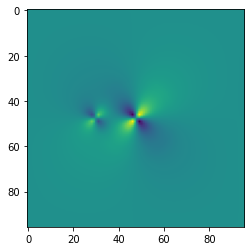

In [6]:
import matplotlib.pyplot as plt
plt.imshow(totalshear[4].imag)

In [7]:
s = time.time()
dmapper =   darkmapper(parser,totalshear.real, totalshear.imag, gErr,lensKer1)

dmapper.lbd=4.      # Lasso penalty. was 8
dmapper.lcd=0.      # Ridge penalty in Elastic net
dmapper.nonNeg=True # using non-negative Lasso
dmapper.clean_outcomes()
dmapper.fista_gradient_descent_fast(3000) # run 3000 steps
w   =   dmapper.adaptive_lasso_weight(gamma=2.) # determine the apaptive weight
dmapper.fista_gradient_descent(3000,w=w)   
e = time.time()# run adaptive lasso
print(e-s)

140.2621021270752


In [8]:
s = time.time()
dmapper.mu=3e-3     # step size for gradient descent
for _ in range(3):  # redo apaptive lasso, letting it run for more iteration
    w   =   dmapper.adaptive_lasso_weight(gamma=2.)
    dmapper.fista_gradient_descent_fast(3000,w=w)
dmapper.reconstruct()
e = time.time()
print(e-s)

320.0096871852875


In [9]:
Grid.zlcgrid

array([0.0625, 0.1075, 0.1525, 0.1975, 0.2425, 0.2875, 0.3325, 0.3775,
       0.4225, 0.4675])

In [10]:
c1  =   detect.local_maxima_3D(dmapper.deltaR)
print(c1)
logm_est1=   np.log10((dmapper.alphaR*dmapper._w)[4,0,69,30])+14. # first halo
#logm_est2=   np.log10((dmapper.alphaR*dmapper._w)[3,2,24,63])+14. #second halo
#logm_est3=   np.log10((dmapper.alphaR*dmapper._w)[0,2,70,63])+14. #third halo

(array([[ 0, 48, 48],
       [ 2, 47, 47],
       [ 4, 47, 30]]), array([137.31033445,  63.73173441,  40.33485854]))


/var/folders/vc/1pffqvxd44q6_lz4rrdn58zh0000gn/T/ipykernel_78595/1575318540.py:3: RuntimeWarning: divide by zero encountered in log10
  logm_est1=   np.log10((dmapper.alphaR*dmapper._w)[4,0,69,30])+14. # first halo


it worked i guess

In [11]:
print("mass 1:", logm_est1)
# print("mass 2:", logm_est2)
# print("mass 3:", logm_est3)
print("true mass 1:", log_m1)
print("true mass 2:", log_m2)
print("true mass 2:", log_m3)
#when c=4, the result only agrees to unit digit

mass 1: -inf
true mass 1: 14.745
true mass 2: 14.79
true mass 2: 14.79


In [12]:
print(dmapper.deltaR.shape)

(10, 96, 96)


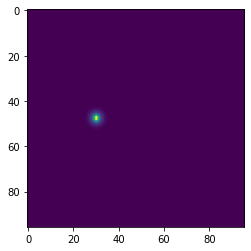

In [13]:
import matplotlib.pyplot as plt
plt.imshow(dmapper.deltaR[4])

(10, 1, 96, 96)


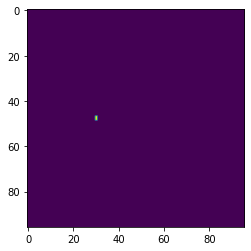

In [14]:
print(dmapper.alphaR.shape)
plt.imshow(dmapper.alphaR[4,0])

In [15]:
print(np.max(dmapper.diff))

0.0002109315401937268
